## Лабораторная работа №2 по СОБД
## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML
## Часть 2
## Датасет "NYC Yellow Taxi Trip Data"
### Объём: 6.88 Гб

## Подключение необходимых библиотек

In [1]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer, Bucketizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.functions import vector_to_array
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

## Инициализация PySpark и создание сессии

In [2]:
conf = SparkConf()
conf.setAppName("Trip Data Analysis")
conf.setMaster("local[*]")  # Локальный режим (все ядра контейнера)
conf.set("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9820")  # Указываем HDFS

conf.set("spark.driver.memory", "8g")           
conf.set("spark.executor.memory", "6g")         
conf.set("spark.memory.fraction", "0.8")        
conf.set("spark.memory.storageFraction", "0.3")

# Настройки для больших данных
conf.set("spark.sql.adaptive.enabled", "true")
conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
conf.set("spark.sql.adaptive.skew.enabled", "true")
conf.set("spark.sql.shuffle.partitions", "100")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

## Загрузка данных

Прочтём преобразованный датасет из Л/Р №1 в формате .parquest

In [3]:
path = "hdfs:///user/vladislav_vaganov/datasets/parquets/tripdata_cleaned.parquet"
df = spark.read.parquet(path)

Выведем датафрейм на экран

In [4]:
df.limit(20).toPandas().style\
    .set_properties(**{'text-align': 'left', 'max-width': '0', 'white-space': 'nowrap', 'overflow': 'hidden', 'text-overflow': 'ellipsis'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .format(precision=2)

,VendorID,passenger_count,trip_distance,haversine_distance,RateCodeID,payment_type,is_airport_trip,pickup_hour,pickup_dow,total_amount
0,2,4,1.57,1.12,1,2,0,23,3,7.80
1,2,1,2.53,1.89,1,1,0,23,3,14.76
2,2,2,6.47,4.61,1,2,0,23,3,22.80
3,2,1,2.62,2.46,1,1,0,23,3,14.12
4,2,1,1.49,1.06,1,2,0,23,3,11.30
5,2,1,3.31,2.42,1,1,0,23,3,21.36
6,2,5,1.31,1.08,1,2,0,23,3,9.80
7,2,1,1.32,0.96,1,2,0,23,3,8.80
8,2,1,5.63,4.30,1,1,0,23,3,30.36
9,2,1,1.99,1.64,1,1,0,23,3,12.96


Выведем схему данных

In [5]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- haversine_distance: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- is_airport_trip: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_dow: integer (nullable = true)
 |-- total_amount: double (nullable = true)



Вычислим количество строк в датафрейме

In [6]:
df.count()

45543284

## Постановка задачи 

Для датасета, заданного представленными колонками, требуется построить модель логистической регрессии для оценки факта того, была ли **совершена поездка в радиусе аэропортов** по всем остальным признакам.

Для оценки качества обучения следует использовать метрики `Precision` и `Recall`. Оценить максимально возможное значение **точности** при полноте не менее 60%.

## Подготовка и кодирование признаков

Столбец **is_airport_trip** уже имеет формат `integer`.

Выполним **стратифицированное** разделение датасета на обучающую и тестовую выборки.

In [7]:
def stratified_train_test_split(data: DataFrame, 
                                label_col: str,
                                ratio: float) -> tuple[DataFrame, DataFrame]:
    """
    Разделяет DataFrame на тренировочный и тестовый наборы с учетом стратификации.

    Args:
        data: Исходный DataFrame.
        label_col: Название столбца с меткой.
        ratio: Пропорция разделения данных.

    Returns:
        tuple[DataFrame, DataFrame]: Кортеж из тренировочного и тестового DataFrame.
    """
    # Проверяем корректность доли разделения
    assert (isinstance(ratio, float) and (0.0 <= ratio <= 1.0))
    
    # Формируем разделение для положительных и отрицательных объектов раздельно
    train_df_pos, test_df_pos = (data
                                 .filter(F.col(label_col) == 1)
                                 .randomSplit([ratio, 1 - ratio]))
    train_df_neg, test_df_neg = (data
                                 .filter(F.col(label_col) == 0)
                                 .randomSplit([ratio, 1 - ratio]))
    
    # Объединяем датафреймы
    return (train_df_pos.union(train_df_neg),
            test_df_pos.union(test_df_neg))

In [8]:
df = df.limit(5000000)

In [9]:
train_df, test_df = stratified_train_test_split(df, "is_airport_trip", 0.8)

Закешируем сформированные датафреймы и проверим их объем.

In [10]:
train_df = train_df.cache()
test_df = test_df.cache()

print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 3999990
Test  dataset size: 1000010


Как мы уже знаем из анализа датасета, если целевой переменной является `is_airport_trip`, то датасет является несбалансированным.

In [11]:
train_df.groupBy("is_airport_trip").count().show()

+---------------+-------+
|is_airport_trip|  count|
+---------------+-------+
|              1| 199851|
|              0|3800139|
+---------------+-------+



Выполним балансировку датасета с помощью `oversampling`.

In [12]:
def oversample(data: DataFrame, column: str) -> DataFrame:
    """
    Выполняет oversampling положительных классов в DataFrame.

    Args:
        data: Исходный DataFrame.
        column: Название столбца с меткой.

    Returns:
        DataFrame: Датафрейм с выполненным oversampling.
    """
    # Разделим датафрейм на положительные и отрицательные классы
    pos = data.filter(F.col(column) == 1.0)
    neg = data.filter(F.col(column) == 0.0)

    # Получим количество записей в каждом классе
    total_pos = pos.count()
    total_neg = neg.count()

    # Если количество положительных классов меньше отрицательных,
    # выполним oversampling
    if total_pos < total_neg:
        # Вычислим количество необходимых дубликатов
        num_duplicates = total_neg - total_pos

        # Дублируем положительные записи
        oversampled_pos = pos.withColumn(
            "dummy",
            F.explode(
                F.array_repeat(F.lit(1),
                               num_duplicates // total_pos + 1)
            )
        ).drop("dummy")

        # Объединим дублированные положительные записи с отрицательными
        balanced_df = neg.union(oversampled_pos)
    else:
        balanced_df = data

    return balanced_df

In [13]:
train_df = oversample(train_df, column="is_airport_trip")

Проверим баланс классов в получившемся датасете.

In [14]:
train_df.groupBy("is_airport_trip").count().show()

+---------------+-------+
|is_airport_trip|  count|
+---------------+-------+
|              0|3800139|
|              1|3797169|
+---------------+-------+



Исходя из построенной корреляционной матрицы в Л/Р №1 ясно, что признаки [**VendorID**, **pickup_hour**, **pickup_dow**] не оказывают прямого и значимого влияния на **is_airport_trip**. Использовать их в модели нет смысла.

Остальные признаки сгруппируем по их типам:

**Категориальные** признаки закодируем `one-hot`-кодировкой.

**Бинарные** признаки отсутствуют.

**Количественные признаки** в кодировке не нуждаются 

In [15]:
# Признаки с минимальным влиянием
low_impact_features = ["VendorID", "pickup_hour", "pickup_dow"]

# Категориальные признаки
categorical_features = ["RateCodeID", "payment_type"]

# Бинарные признаки
binary_features = []

# Количественные признаки
numeric_features = ["trip_distance", "haversine_distance", "total_amount"]

Создадим конвейер обработки данных, включающий модель логистической регрессии.

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
                    binary_features: list[str], label_col: str, max_iter: int) -> Pipeline:
    """
    Создает конвейер для обработки данных и обучения модели логистической регрессии.

    Args:
        categorical_features: Список категориальных признаков.
        numeric_features: Список количественных признаков.
        binary_features: Список бинарных признаков.
        label_col: Название столбца с меткой.
        max_iter: Максимальное количество итераций для модели.

    Returns:
        Pipeline: Конвейер для обработки данных и обучения модели.
    """
    
    stages = []
    
    # 1. Обработка категориальных признаков: StringIndexer + OneHotEncoder
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    encoded_categorical_features = [f"{feature}_encoded" for feature in categorical_features]
    
    string_indexer = StringIndexer(
        inputCols=categorical_features,
        outputCols=indexed_categorical_features,
        handleInvalid="keep"
    )
    stages.append(string_indexer)
    
    one_hot_encoder = OneHotEncoder(
        inputCols=indexed_categorical_features,
        outputCols=encoded_categorical_features
    )
    stages.append(one_hot_encoder)
    
    # 2. Масштабирование количественных признаков (рекомендуется для Logistic Regression)
    scaled_numeric_features = [f"{feature}_scaled" for feature in numeric_features]
    
    numeric_assembler = VectorAssembler(
        inputCols=numeric_features,
        outputCol="numeric_vector"
    )
    stages.append(numeric_assembler)
    
    scaler = StandardScaler(
        inputCol="numeric_vector",
        outputCol="numeric_scaled",
        withStd=True,
        withMean=True
    )
    stages.append(scaler)
    
    # 3. Объединение всех признаков
    all_features = encoded_categorical_features + binary_features + ["numeric_scaled"]
    
    vector_assembler = VectorAssembler(
        inputCols=all_features,
        outputCol="features"
    )
    stages.append(vector_assembler)
    
    # 4. Создание модели Logistic Regression
    lr_classifier = LogisticRegression(
        featuresCol="features",
        labelCol=label_col,
        predictionCol="prediction",
        maxIter=max_iter,
        regParam=0.01  # Добавляем регуляризацию
    )
    stages.append(lr_classifier)
    
    # Создаем конвейер
    pipeline = Pipeline(stages=stages)
    
    return pipeline

In [17]:
pipeline = create_pipeline(
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    binary_features=binary_features,
    label_col="is_airport_trip",
    max_iter=50
)
print("Конвейер успешно создан!")

Конвейер успешно создан!


## Обучение модели

Выполним подбор **гиперпараметров** модели логистической регрессии с помощью кросс-валидации на сетке.

In [18]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].regParam, [0.1]) \
    .addGrid(pipeline.getStages()[-1].elasticNetParam, [0.5]) \
    .addGrid(pipeline.getStages()[-1].maxIter, [50]) \
    .build()

Создаем экземпляр `BinaryClassificationEvaluator` для оценки модели.

In [19]:
evaluator = BinaryClassificationEvaluator(labelCol="is_airport_trip")

Создаем объект `CrossValidator`

In [20]:
crossval = CrossValidator(estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    parallelism=4,                   
    numFolds=2)

Обучаем модель конвейера с использованием кросс-валидации.

In [21]:
cv_model = crossval.fit(train_df)
print("Обучение завершено")

Обучение завершено


Выведем параметры лучшей модели, определенной в ходе кросс-валидации.

In [22]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model: Объект CrossValidatorModel, содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    lr_model = best_model.stages[-1]  # Получаем объект LogisticRegression
    
    best_params = {
        "regParam": lr_model.getRegParam(),
        "elasticNetParam": lr_model.getElasticNetParam(),
        "maxIter": lr_model.getMaxIter(),
    }
    return best_params

In [23]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

regParam: 0.1
elasticNetParam: 0.5
maxIter: 50


## Анализ обученной модели

Рассчитаем метрики на тестовом датасете

In [24]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем целевую переменную на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("is_airport_trip")
right_columns_order.append("is_airport_trip")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.limit(20).toPandas().style\
    .set_properties(**{'text-align': 'left', 'max-width': '0', 'white-space': 'nowrap', 'overflow': 'hidden', 'text-overflow': 'ellipsis'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .format(precision=2)

,VendorID,passenger_count,trip_distance,haversine_distance,RateCodeID,payment_type,pickup_hour,pickup_dow,total_amount,RateCodeID_index,payment_type_index,RateCodeID_encoded,payment_type_encoded,numeric_vector,numeric_scaled,features,rawPrediction,probability,prediction,is_airport_trip
0,1,1,0.10,0.03,5,1,15,5,48.35,4.00,0.00,"(7,[4],[1.0])","(2,[0],[1.0])","[0.1,0.030888407606063074,48.35]","[-1.1831257868380094,-1.1753387099833355,0.8936844618070161]","(12,[4,7,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1753387099833355,0.8936844618070161])","[0.5812504133891107,-0.5812504133891107]","[0.6413550756590193,0.3586449243409807]",0.00,1
1,1,1,0.10,0.05,1,2,16,7,3.30,0.00,1.00,"(7,[0],[1.0])","(2,[1],[1.0])","[0.1,0.04996078444897963,3.3]","[-1.1831257868380094,-1.1706783053074652,-1.3114724049430664]","(12,[0,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1706783053074652,-1.3114724049430664])","[2.258618663705853,-2.258618663705853]","[0.905391375016186,0.09460862498381395]",0.00,1
2,1,1,0.10,0.05,3,2,21,5,20.80,3.00,1.00,"(7,[3],[1.0])","(2,[1],[1.0])","[0.1,0.050426806676135416,20.8]","[-1.1831257868380094,-1.1705644310806511,-0.45486318922438845]","(12,[3,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1705644310806511,-0.45486318922438845])","[1.6061490224824977,-1.6061490224824977]","[0.8328760421476844,0.1671239578523156]",0.00,1
3,1,1,0.10,0.06,2,2,16,6,57.30,1.00,1.00,"(7,[1],[1.0])","(2,[1],[1.0])","[0.1,0.0561760634299721,57.3]","[-1.1831257868380094,-1.1691595792743432,1.3317788892745683]","(12,[1,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1691595792743432,1.3317788892745683])","[0.24474764308325048,-0.24474764308325048]","[0.5608832974813353,0.43911670251866475]",0.00,1
4,1,1,0.10,0.06,1,2,12,6,3.30,0.00,1.00,"(7,[0],[1.0])","(2,[1],[1.0])","[0.1,0.05694048725620053,3.3]","[-1.1831257868380094,-1.1689727895310698,-1.3114724049430664]","(12,[0,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1689727895310698,-1.3114724049430664])","[2.2578353682305154,-2.2578353682305154]","[0.9053242583142325,0.09467574168576753]",0.00,1
5,1,1,0.10,0.06,1,2,20,7,3.80,0.00,1.00,"(7,[0],[1.0])","(2,[1],[1.0])","[0.1,0.06237519297413098,3.8]","[-1.1831257868380094,-1.1676447994148706,-1.2869978559225328]","(12,[0,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1676447994148706,-1.2869978559225328])","[2.2385849641979276,-2.2385849641979276]","[0.9036613391226277,0.0963386608773723]",0.00,1
6,1,1,0.10,0.07,1,2,14,6,3.30,0.00,1.00,"(7,[0],[1.0])","(2,[1],[1.0])","[0.1,0.06720157737361468,3.3]","[-1.1831257868380094,-1.166465454826194,-1.3114724049430664]","(12,[0,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.166465454826194,-1.3114724049430664])","[2.2566838198504495,-2.2566838198504495]","[0.9052255104369265,0.09477448956307355]",0.00,1
7,1,1,0.10,0.08,1,2,16,7,3.80,0.00,1.00,"(7,[0],[1.0])","(2,[1],[1.0])","[0.1,0.08003242004282766,3.8]","[-1.1831257868380094,-1.1633301917353138,-1.2869978559225328]","(12,[0,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1633301917353138,-1.2869978559225328])","[2.236603386120476,-2.236603386120476]","[0.9034886897996223,0.09651131020037773]",0.00,1
8,1,1,0.10,0.09,3,2,20,7,20.80,3.00,1.00,"(7,[3],[1.0])","(2,[1],[1.0])","[0.1,0.09480869694250604,20.8]","[-1.1831257868380094,-1.1597195547118122,-0.45486318922438845]","(12,[3,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.1597195547118122,-0.45486318922438845])","[1.6011682754804042,-1.6011682754804042]","[0.83218160441557,0.16781839558443]",0.00,1
9,1,1,0.10,0.10,1,2,8,5,3.80,0.00,1.00,"(7,[0],[1.0])","(2,[1],[1.0])","[0.1,0.10124738062596712,3.8]","[-1.1831257868380094,-1.15814623892679,-1.2869978559225328]","(12,[0,8,9,10,11],[1.0,1.0,-1.1831257868380094,-1.15814623892679,-1.2869978559225328])","[2.234222542251731,-2.234222542251731]","[0.9032808881239726,0.09671911187602744]",0.00,1


In [25]:
def evaluate_model(data: DataFrame, 
                   label_col: str) -> dict[str, float]:
    """
    Оценивает модель с использованием метрик точности, полноты и F1-score.

    Args:
        data: DataFrame, содержащий предсказания и фактические метки.
        label_col: Название колонки с меткой.

    Returns:
        dict[str, float]: Словарь с метриками точности, полноты и F1-score.
    """
    # Вычисляем TP, FP, FN
    tp = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 1)).count()
    fp = data.filter((F.col(label_col) == 0) &
                     (F.col("prediction") == 1)).count()
    fn = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 0)).count()

    # Вычисляем метрики
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0 else 0)

    # Возвращаем словарь с метриками
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [26]:
metrics = evaluate_model(test_df_predictions, "is_airport_trip")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.5162109265783146, 'recall': 0.9237496747853583, 'f1': 0.6623093369301631}


Наблюдаем среднюю точность в виде 51% при высокой полноте в 92%. Попробуем подобрать `threshold`, чтобы максимизировать точность, но при этом удерживать полноту на заданном в постановке задачи уровне. Сначала рассчитаем `AUC ROC`, визуализируем `ROC` и `PR`-кривые и оценим ситуацию.

In [27]:
from pyspark.ml import PipelineModel

def calculate_auc_roc(model: PipelineModel, 
                      test_data: DataFrame,
                      label_col: str) -> float:
    """
    Рассчитывает значение AUC ROC для модели Logistic Regression.

    Args:
        model: Обученная pipeline модель, содержащая LogisticRegressionModel.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        float: Значение AUC ROC.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Создаем "оценщик" бинарной классификации
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction",  # Для LogisticRegression используется rawPrediction
        labelCol=label_col,
        metricName="areaUnderROC"
    )

    # Вычисляем AUC ROC
    auc_roc = evaluator.evaluate(predictions)

    return auc_roc

In [28]:
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType

def prepare_metrics_df(predictions: DataFrame, label_col: str) -> DataFrame:
    """
    Подготавливает DataFrame для расчета FPR, TPR и Precision для Logistic Regression.

    Args:
        predictions: DataFrame с прогнозами модели.
        label_col: Название столбца с меткой.

    Returns:
        DataFrame: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
    """
    # Формируем датафрейм, содержащий результат предсказания,
    # вероятность предсказания и метку
    metrics_df = (
        predictions
        .select(
            # Для бинарной классификации берем вероятность класса 1
            vector_to_array(F.col("probability")).getItem(1).alias("probability"),
            F.col(label_col).alias("label"),
            F.col("prediction").cast("int").alias("prediction")
        )
    )

    # Сортируем датафрейм по значениям вероятности (по убыванию для ROC)
    metrics_df = metrics_df.orderBy(F.desc("probability"))

    # Рассчитываем количество положительных и отрицательных классов
    pos_count = metrics_df.filter(F.col("label") == 1).count()
    neg_count = metrics_df.filter(F.col("label") == 0).count()

    # Рассчитываем значения FPR и TPR с накопительным итогом
    window = Window.orderBy(F.desc("probability"))
    metrics_df = (
        metrics_df
        .withColumn("FP_cum", 
                    F.sum(F.when(F.col("label") == 0, 1).otherwise(0)).over(window))
        .withColumn("TP_cum", F.sum(F.col("label")).over(window))
        .withColumn("FPR", F.col("FP_cum") / F.lit(neg_count))
        .withColumn("TPR", F.col("TP_cum") / F.lit(pos_count))
        .withColumn("Precision", 
                    F.when((F.col("TP_cum") + F.col("FP_cum")) > 0,
                           F.col("TP_cum") / (F.col("TP_cum") + F.col("FP_cum")))
                    .otherwise(0.0))
    )

    return metrics_df

In [29]:
def bucketize_metrics_df(metrics_df: DataFrame, 
                         num_buckets: int = 1000) -> DataFrame:
    """
    Применяет Bucketizer к DataFrame для уменьшения объёма данных, 
    возвращаемых на драйвер.

    Args:
        metrics_df: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
        num_buckets: Количество бакетов.

    Returns:
        DataFrame: Бакетизированный Dataframe.
    """
    # Определяем границы бакетов
    bucketizer = Bucketizer(
        splits=list(np.linspace(0, 1, num_buckets + 1)),
        inputCol="probability",
        outputCol="bucket"
    )

    # Применяем Bucketizer
    metrics_df = bucketizer.setHandleInvalid("error").transform(metrics_df)

    # Формируем одну точку из каждого бакета
    metrics_df = metrics_df.groupBy("bucket").agg(
        F.avg(F.col("probability")).alias("probability"),
        F.avg(F.col("FPR")).alias("FPR"),
        F.avg(F.col("TPR")).alias("TPR"),
        F.avg(F.col("Precision")).alias("Precision")
    )

    return metrics_df

In [30]:
def calculate_metrics(model: PipelineModel, 
                      test_data: DataFrame,
                      label_col: str) -> pd.DataFrame:
    """
    Рассчитывает значения FPR, TPR и Precision для построения ROC и PR-кривых.

    Args:
        model: Обученная pipeline модель, содержащая LogisticRegressionModel.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        pd.DataFrame: DataFrame со значениями FPR, TPR и Precision.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Подготавливаем DataFrame для расчета FPR, TPR и Precision
    metrics_df = prepare_metrics_df(predictions, label_col)

    # Применяем Bucketizer к DataFrame
    metrics_df = bucketize_metrics_df(metrics_df)

    return metrics_df.toPandas()

In [31]:
def plot_roc_pr_curves(pd_data: pd.DataFrame, 
                       auc_roc: float) -> None:
    """
    Визуализирует ROC и PR-кривые, добавляет на график AUC ROC.

    Args:
        pd_data: Pandas DataFrame, содержащий столбцы 
            "FPR", "TPR", "Precision".
        auc_roc: Значение AUC-ROC.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Построение ROC-кривой
    sns.lineplot(x="FPR", y="TPR", data=pd_data, ax=axes[0])
    sns.lineplot(x=[0, 1], y=[0, 1], 
                 color="gray", linestyle="--", ax=axes[0])
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].set_title("ROC Curve")
    axes[0].grid()

    # Добавляем значение AUC-ROC в правом нижнем углу графика
    axes[0].text(0.94, 0.06, f'AUC-ROC: {auc_roc:.2f}', 
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment='bottom', 
                 horizontalalignment='right',
                 bbox=dict(facecolor='white', 
                           alpha=0.8), zorder=5)

    # Построение PR-кривой
    sns.lineplot(x="TPR", y="Precision", 
                 data=pd_data, ax=axes[1])
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("PR Curve")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

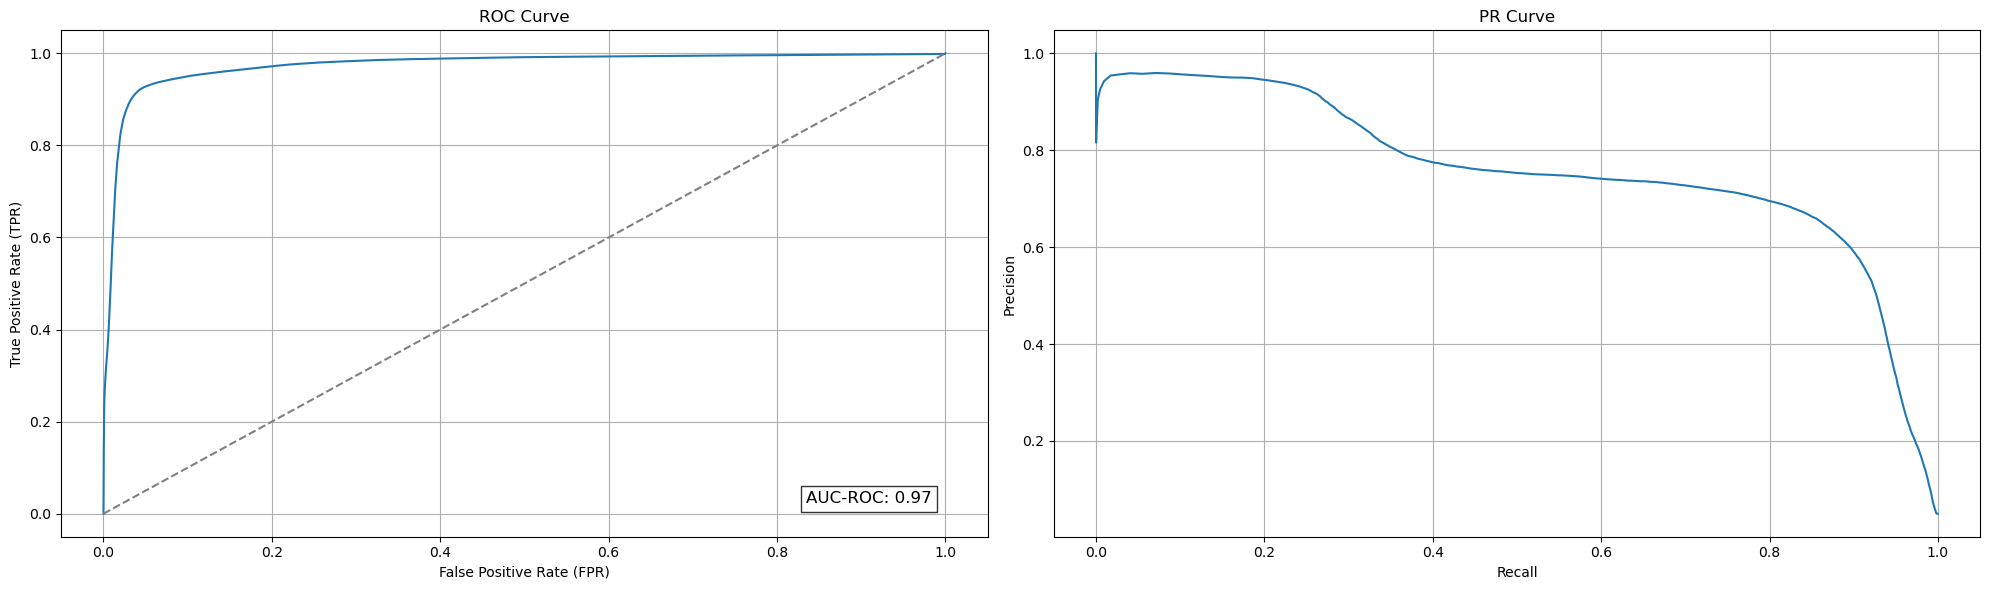

In [32]:
# Рассчитываем AUC ROC
auc_roc = calculate_auc_roc(model=cv_model,
                            test_data=test_df,
                            label_col="is_airport_trip")
pd_dataframe = calculate_metrics(model=cv_model,
                                 test_data=test_df,
                                 label_col="is_airport_trip")
plot_roc_pr_curves(pd_dataframe, auc_roc)

Определим вероятность -- границу разделения, при которой `Recall` не меньше 60%.


In [33]:
threshold_probability = pd_dataframe[pd_dataframe['TPR'] >= 0.60]['probability'].max()
print(f"Вероятность -- граница разделения, при которой TPR не меньше 60%: {threshold_probability:.2f}")

Вероятность -- граница разделения, при которой TPR не меньше 60%: 0.77


In [34]:
cv_model.bestModel.stages[-1].setThresholds([1 - threshold_probability, 
                                             threshold_probability])
test_df_predictions = cv_model.transform(test_df)
metrics = evaluate_model(test_df_predictions, "is_airport_trip")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.7409650418513047, 'recall': 0.6023575559869514, 'f1': 0.6645103602062106}


Обученная модель не обладает достаточно высоким качеством, так как при полноте в 60% точность составляет 75%. Для дальнейшего улучшения модели необходимо добавить дополнительные данные, которые будут сильнее коррелировать с признаком `is_airport_trip`.

## Сохранение модели

Зададим директорию, в которой будет сохранена обученная модель.

In [35]:
model_path = "hdfs:///user/vladislav_vaganov/datasets/logistic_regression_taxi_model"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.write().overwrite().save(model_path)
    print(f"Модель успешно сохранена в: {model_path}")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Модель успешно сохранена в: hdfs:///user/vladislav_vaganov/datasets/logistic_regression_taxi_model


In [36]:
spark.stop()